<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Obtain:-Load-Data" data-toc-modified-id="Obtain:-Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Obtain: Load Data</a></span></li><li><span><a href="#Scrub-and-Explore:" data-toc-modified-id="Scrub-and-Explore:-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scrub and Explore:</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-Classification-Labels" data-toc-modified-id="Analysis-of-Classification-Labels-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Analysis of Classification Labels</a></span></li><li><span><a href="#Rescale-and-Reshape-data" data-toc-modified-id="Rescale-and-Reshape-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Rescale and Reshape data</a></span></li></ul></li><li><span><a href="#Functions:" data-toc-modified-id="Functions:-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Functions:</a></span></li><li><span><a href="#Models:" data-toc-modified-id="Models:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Models:</a></span><ul class="toc-item"><li><span><a href="#Baseline" data-toc-modified-id="Baseline-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Baseline</a></span></li><li><span><a href="#MLP-with-Dropout" data-toc-modified-id="MLP-with-Dropout-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>MLP with Dropout</a></span></li><li><span><a href="#CNN" data-toc-modified-id="CNN-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CNN</a></span><ul class="toc-item"><li><span><a href="#TensorBoard" data-toc-modified-id="TensorBoard-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>TensorBoard</a></span></li><li><span><a href="#View-Feature-Maps" data-toc-modified-id="View-Feature-Maps-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>View Feature Maps</a></span></li><li><span><a href="#View-First-Activation-Layer" data-toc-modified-id="View-First-Activation-Layer-5.3.3"><span class="toc-item-num">5.3.3&nbsp;&nbsp;</span>View First Activation Layer</a></span></li></ul></li><li><span><a href="#CNN-with-Augmentation" data-toc-modified-id="CNN-with-Augmentation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>CNN with Augmentation</a></span><ul class="toc-item"><li><span><a href="#View-Augmented-Images" data-toc-modified-id="View-Augmented-Images-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>View Augmented Images</a></span></li><li><span><a href="#View-Feature-Maps" data-toc-modified-id="View-Feature-Maps-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>View Feature Maps</a></span></li></ul></li><li><span><a href="#CNN-with-Dropout-and-Class-Weights" data-toc-modified-id="CNN-with-Dropout-and-Class-Weights-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>CNN with Dropout and Class Weights</a></span></li><li><span><a href="#L2-Regularization" data-toc-modified-id="L2-Regularization-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>L2 Regularization</a></span></li><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Transfer Learning</a></span></li></ul></li><li><span><a href="#Results:" data-toc-modified-id="Results:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results:</a></span><ul class="toc-item"><li><span><a href="#See-Results-from-Models" data-toc-modified-id="See-Results-from-Models-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>See Results from Models</a></span></li><li><span><a href="#See-Test-Results" data-toc-modified-id="See-Test-Results-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>See Test Results</a></span></li><li><span><a href="#Confusion-Matrices-for-Test-Set" data-toc-modified-id="Confusion-Matrices-for-Test-Set-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Confusion Matrices for Test Set</a></span></li></ul></li><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusion:</a></span></li></ul></div>

# Detecting Pneumonia 
--- 
Image classification with Machine Learning

By: Cassie Nutter

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import array_to_img, img_to_array
import datetime
from keras import layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras import regularizers
import os, shutil
from keras.applications import VGG19
from keras.utils import plot_model

%load_ext tensorboard

from sklearn.metrics import classification_report, confusion_matrix, \
plot_confusion_matrix

np.random.seed(100)
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from scipy import ndimage
from keras.models import load_model

## Obtain: Load Data
--- 
Data used for this analysis comes from Kaggle. You can find the data [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In [2]:
# set directory paths
data_test_dir = '../data_chest_xray/test/'
data_train_dir = '../data_chest_xray/train/'
data_val_dir = '../data_chest_xray/val/'
main_dir = 'split/'

In [3]:
# create new directory
os.mkdir(main_dir)

In [4]:
#create folders and subfolders to put in new directory

train_folder = os.path.join(main_dir, 'train')
#train folder data
train_pneum = os.path.join(train_folder, 'PNEUMONIA/')
train_norm = os.path.join(train_folder, 'NORMAL/')

test_folder = os.path.join(main_dir, 'test/')
#test folder data
test_pneum = os.path.join(test_folder, 'PNEUMONIA/')
test_norm = os.path.join(test_folder, 'NORMAL/')

val_folder = os.path.join(main_dir, 'val/')
#validation folder data
val_pneum = os.path.join(val_folder, 'PNEUMONIA/')
val_norm = os.path.join(val_folder, 'NORMAL/')

An 80 / 10 / 10 split would be best. Right now, there isn't enough data to accurately validate our models. So let's move 10% of data from the training set to the validation set.

In [5]:
# check the path
train_norm

'split/train/NORMAL/'

In [6]:
# add the folders to the directory
folders = [train_folder, train_pneum, train_norm, test_folder, test_pneum, 
           test_norm, val_folder, val_pneum, val_norm]

make_dirs = [os.mkdir(folder) for folder in folders]

In [7]:
# function to move images from original dataset to new dataset
def copy_images(directory, label, dest):
    imgs = [file for file in os.listdir(directory + label) if file.endswith('.jpeg')]
    for img in imgs:
        origin = os.path.join(directory + label, img)
        destination = os.path.join(dest, img)
        shutil.copyfile(origin, destination)

In [8]:
# copy images from original dataset to new folders
# train data
copy_images(data_train_dir, 'PNEUMONIA/', train_pneum)
copy_images(data_train_dir, 'NORMAL/', train_norm)

# test data
copy_images(data_test_dir, 'PNEUMONIA/', test_pneum)
copy_images(data_test_dir, 'NORMAL/', test_norm)

# validation data
copy_images(data_val_dir, 'PNEUMONIA/', val_pneum)
copy_images(data_val_dir, 'NORMAL/', val_norm)

In [9]:
# count images in each folder to verify it is the same as original
img_folders = [train_pneum, train_norm, test_pneum, test_norm, 
               val_pneum, val_norm]
folder_values = [print(f'{len(os.listdir(i))} images in folder {i}') \
          for i in img_folders]

3875 images in folder split/train/PNEUMONIA/
1341 images in folder split/train/NORMAL/
390 images in folder split/test/PNEUMONIA/
234 images in folder split/test/NORMAL/
8 images in folder split/val/PNEUMONIA/
8 images in folder split/val/NORMAL/


In [10]:
# Does this match what Kaggle says? Should have 5856 images
total = sum([len(os.listdir(i)) for i in img_folders])
total

5856

In [11]:
# view % in each set
train_total = len(os.listdir(train_pneum)) + len(os.listdir(train_norm))
test_total = len(os.listdir(test_pneum)) + len(os.listdir(test_norm))
val_total = len(os.listdir(val_pneum)) + len(os.listdir(val_norm))

print(f'Percentage of data for training: {round(train_total / total * 100, 2)}%')
print(f'Percentage of data for testing: {round(test_total / total * 100, 2)}%')
print(f'Percentage of data for validation: {round(val_total / total * 100, 2)}%')

Percentage of data for training: 89.07%
Percentage of data for testing: 10.66%
Percentage of data for validation: 0.27%


In [12]:
# store all images
imgs_train_pneum = [file for file in os.listdir(train_pneum)]
imgs_train_norm = [file for file in os.listdir(train_norm)]

In [13]:
# Take 7% pneumonia from training data
imgs = imgs_train_pneum[:410]
for img in imgs:
    origin = os.path.join(train_pneum, img)
    destination = os.path.join(val_pneum, img)
    shutil.move(origin, destination)

# Take ~3% normal from training data
imgs2 = imgs_train_norm[:150]
for img in imgs2:
    origin = os.path.join(train_norm, img)
    destination = os.path.join(val_norm, img)
    shutil.move(origin, destination)

In [14]:
# see how it worked
train_total = len(os.listdir(train_pneum)) + len(os.listdir(train_norm))
test_total = len(os.listdir(test_pneum)) + len(os.listdir(test_norm))
val_total = len(os.listdir(val_pneum)) + len(os.listdir(val_norm))

print(f'Percentage of data for training: {round(train_total / total * 100, 2)}%')
print(f'Percentage of data for testing: {round(test_total / total * 100, 2)}%')
print(f'Percentage of data for validation: {round(val_total / total * 100, 2)}%')

Percentage of data for training: 79.51%
Percentage of data for testing: 10.66%
Percentage of data for validation: 9.84%


Not exactly 80 / 10 / 10 but very close. Let's keep going.

## Scrub and Explore:
---
Let's see what the images look like, then make sure they are in a form our models can understand.

Text(0.5, 1.0, 'PNEUMONIA')

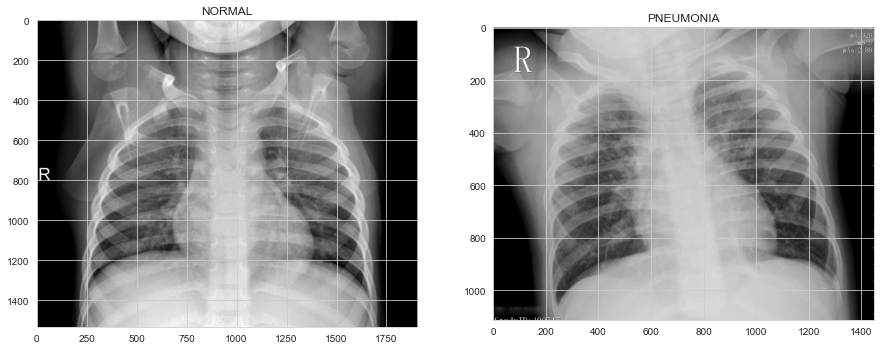

In [15]:
# Pick 2 images - one from each classification
img_name = 'NORMAL2-IM-0509-0001.jpeg'
img_normal = load_img(train_norm + img_name)

img_name2 = 'person359_virus_738.jpeg'
img_pneum = load_img(train_pneum + img_name2)

# view those images
fig = plt.figure(figsize= (15,10))
ax1 = fig.add_subplot(1,2,1)
img_plt = plt.imshow(img_normal)
ax1.set_title('NORMAL')

ax2 = fig.add_subplot(1,2,2)
img_plt = plt.imshow(img_pneum)
ax2.set_title('PNEUMONIA')

### Analysis of Classification Labels
---
Judging from what we saw already, there seems to be a class imbalance. Let's take a closer look.

In [16]:
# make a DataFrame to visualize data
train_df = []
for file in os.listdir(train_norm):
    train_df.append((file, 0))
for file in os.listdir(train_pneum):
    train_df.append((file, 1))
train_df = pd.DataFrame(train_df, columns= (['image', 'label']))

In [17]:
print(train_df.info())
train_df.head(-10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4656 entries, 0 to 4655
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4656 non-null   object
 1   label   4656 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 72.9+ KB
None


,image,label
0,NORMAL2-IM-0410-0001.jpeg,0
1,IM-0471-0001.jpeg,0
2,NORMAL2-IM-1236-0001.jpeg,0
3,IM-0647-0001.jpeg,0
4,IM-0537-0001.jpeg,0
...,...,...
4641,person1164_virus_1958.jpeg,1
4642,person1461_virus_2510.jpeg,1
4643,person23_bacteria_101.jpeg,1
4644,person344_bacteria_1585.jpeg,1


In [18]:
# even though this is only checking the image name, better to check it now
train_df.duplicated().sum()

0

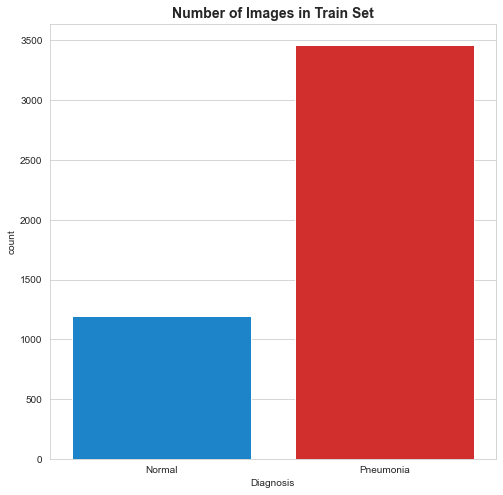

In [19]:
# visualize counts for training data
pal = ['#008ae6' , '#ec1313']
plt.figure(figsize= (8,8))
sns.countplot(x=train_df['label'], data= train_df, palette= pal)
plt.xlabel('Diagnosis')
plt.title('Number of Images in Train Set', fontsize= 14, fontweight= 'bold')
plt.xticks(range(len(train_df['label'].value_counts())), ['Normal', 'Pneumonia'])
plt.show()

In [20]:
#repeat for test and validation data
test_df = []
for file in os.listdir(test_norm):
    test_df.append((file, 0))
for file in os.listdir(test_pneum):
    test_df.append((file, 1))
test_df = pd.DataFrame(test_df, columns= (['image', 'label']))

val_df = []
for file in os.listdir(val_norm):
    val_df.append((file, 0))
for file in os.listdir(val_pneum):
    val_df.append((file, 1))
val_df = pd.DataFrame(val_df, columns= (['image', 'label']))

In [21]:
# check for duplicate image names
print(test_df.duplicated().sum())
val_df.duplicated().sum()

0


0

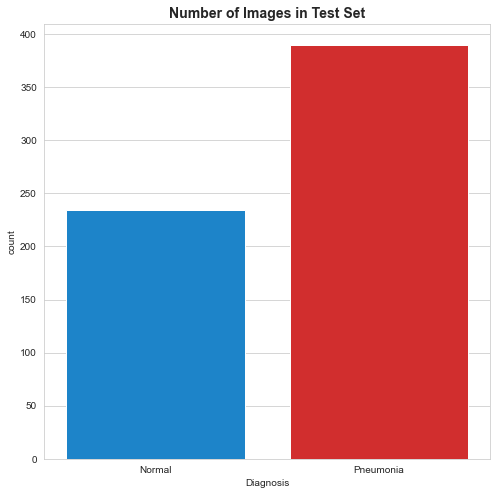

In [22]:
#plot test image counts
pal = ['#008ae6' , '#ec1313']
plt.figure(figsize= (8,8))
sns.countplot(x=test_df['label'], data= test_df, palette= pal)
plt.xlabel('Diagnosis')
plt.title('Number of Images in Test Set', fontsize= 14, fontweight= 'bold')
plt.xticks(range(len(test_df['label'].value_counts())), ['Normal', 'Pneumonia'])
plt.show()

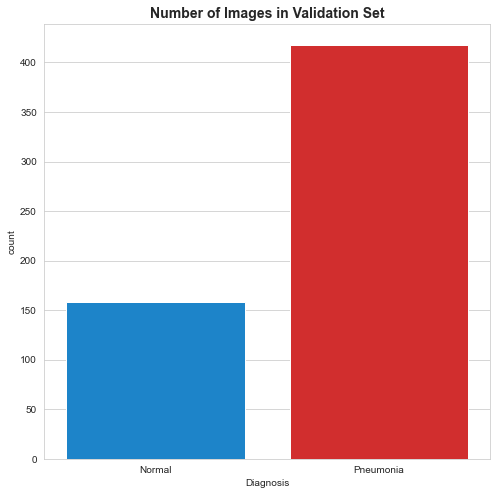

In [23]:
# visualize image counts in validation set
pal = ['#008ae6' , '#ec1313']
plt.figure(figsize= (8,8))
sns.countplot(x=val_df['label'], data= val_df, palette= pal)
plt.xlabel('Diagnosis')
plt.title('Number of Images in Validation Set', fontsize= 14, fontweight= 'bold')
plt.xticks(range(len(val_df['label'].value_counts())), ['Normal', 'Pneumonia'])
plt.show()

In [24]:
# see what % of data is in each class
print(train_df['label'].value_counts(normalize= True))
print(test_df['label'].value_counts(normalize= True))
val_df['label'].value_counts(normalize= True)

1    0.744201
0    0.255799
Name: label, dtype: float64
1    0.625
0    0.375
Name: label, dtype: float64


1    0.725694
0    0.274306
Name: label, dtype: float64

The test data has the most balanced data, though it is still far from being 50/50. Approximately one quarter of training and validation data is a "Normal" X-ray and three-quarter labeled "Pneumonia".

### Rescale and Reshape data

We will need to do some preprocessing to get the images ready to be modeled.

The most important thing we can do now is make sure all the images settings are identical.

In [25]:
# get set sizes
print('Training set size:', train_total)
print('Test set size:', test_total)
print('Validation set size:', val_total)

Training set size: 4656
Test set size: 624
Validation set size: 576


In [26]:
# ImageDataGenerator is a constructor that scales pixel values and 
# can augment versions of images
# flow_from_directory() function iterates through images in a folder

# rescale will transform the pixel values from 1-255 to 0-1
train_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
    train_folder, 
    target_size= (150,150), 
    batch_size= 4656, 
    class_mode= 'binary')

test_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
    test_folder, 
    target_size= (150,150), 
    batch_size= 624, 
    class_mode= 'binary')

val_generator = ImageDataGenerator(rescale= 1./255).flow_from_directory(
    val_folder, 
    target_size= (150, 150), 
    batch_size= 576, 
    class_mode= 'binary')

Found 4656 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


In [27]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [28]:
# create the data sets with next()
# next() returns the next item in an iterator
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [29]:
# check num of training samples and pixels for images in train data
print(train_images.shape[0])
train_images.shape[1]

4656


150

In [30]:
# show matrix shape that contains images and labels
print('Train images shape: {}'.format(train_images.shape))
print('Test images shape: {}'.format(test_images.shape))
print('Validation images shape: {}'.format(val_images.shape))
print('--------------------------------')
print('Train labels shape: {}'.format(train_labels.shape))
print('Test labels shape: {}'.format(test_labels.shape))
print('Validation labels shape: {}'.format(val_labels.shape))

Train images shape: (4656, 150, 150, 3)
Test images shape: (624, 150, 150, 3)
Validation images shape: (576, 150, 150, 3)
--------------------------------
Train labels shape: (4656,)
Test labels shape: (624,)
Validation labels shape: (576,)


In [31]:
# reshape the image matrices
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape, test_img.shape, val_img.shape)

(4656, 67500) (624, 67500) (576, 67500)


In [32]:
train_labels

array([1., 1., 0., ..., 0., 0., 1.], dtype=float32)

In [33]:
# reshape labels as well from row vector to column vector
train_y = train_labels.reshape(-1,1)
test_y = test_labels.reshape(-1,1)
val_y = val_labels.reshape(-1,1)
val_y.shape

(576, 1)

## Functions:
---
Functions that will be used to plot accuracy, loss and show classification reports and confusion matrices.

In [34]:
# This function will display the visualiztions of loss and accuracy
# during each epoch

def visualize_results(results):
    history = results.history
    plt.figure(figsize= (18, 5))
    plt.subplot(1,2,1)
    plt.plot(history['val_loss'], color= 'orange')
    plt.plot(history['loss'], color= 'red')
    plt.legend(['Val loss', 'Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(history['val_acc'], color= 'green')
    plt.plot(history['acc'], color= 'blue')
    plt.legend(['Val Accuracy', 'Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [35]:
'''This function will display the results from each model including:
training and validation loss and accuracy, confusion matrices 
and classification reports'''
# create empty list to store results
results_list = []

def get_results(Xtrain, ytrain, Xval, yval, model, model_name, total_time):
    # evaluate results from training and validation data and display
    train_eval = model.evaluate(Xtrain, ytrain, verbose= 0)
    print('Training Data Loss:', train_eval[0])
    print('Training Data Accuracy', train_eval[1])
    print('--------------------------')
    
    val_eval = model.evaluate(Xval, yval, verbose= 0)
    print('Validation Data Loss:', val_eval[0])
    print('Validation Data Accuracy', val_eval[1], '\n')

    
    # print classification report
    y_pred = model.predict(Xval)
    y_pred = np.rint(y_pred)
    print(classification_report(yval, y_pred))
    
    # display confusion matrix
    cm = confusion_matrix(yval, y_pred)
    FN = cm[1][0]
    
    plt.figure(figsize= (5,5))
    categories = ['Normal', 'Pneumonia']
    sns.heatmap(cm, annot= True, cmap='Blues', fmt= 'g', 
                xticklabels= categories, yticklabels= categories, cbar= False, 
                linewidths= 1, linecolor='gray')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('{} Confusion Matrix'.format(model_name), fontsize= 14, fontweight= 'bold')
    
    # add results to list
    results_list.append((model_name, round(train_eval[0],4), round(val_eval[0],4), 
                         round(train_eval[1]*100,2), round(val_eval[1]*100,2), 
                         FN, total_time))

## Models:

### Baseline
First, a baseline model:

In [36]:
# build baseline model with 3 hidden layers
baseline = Sequential()
baseline.add(layers.Dense(64, activation= 'relu', input_shape= (67500,)))
baseline.add(layers.Dense(32, activation= 'relu'))
baseline.add(layers.Dense(16, activation= 'relu'))
baseline.add(layers.Dense(1, activation= 'sigmoid'))

# compile and fit the model
baseline.compile(optimizer= 'sgd', loss= 'binary_crossentropy', metrics= ['acc'])

start = datetime.datetime.now()
history = baseline.fit(train_img, 
                    train_y, 
                    epochs= 50, 
                    batch_size= 32, #default
                    validation_data= (val_img, val_y))
end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/50
146/146 [==============================] - 1s 9ms/step - loss: 0.4873 - acc: 0.7629 - val_loss: 0.3440 - val_acc: 0.8333
Epoch 2/50
146/146 [==============================] - 1s 7ms/step - loss: 0.3637 - acc: 0.8413 - val_loss: 0.2595 - val_acc: 0.9097
Epoch 3/50
146/146 [==============================] - 1s 7ms/step - loss: 0.2821 - acc: 0.8849 - val_loss: 0.1933 - val_acc: 0.9271
Epoch 4/50
146/146 [==============================] - 1s 7ms/step - loss: 0.2277 - acc: 0.9091 - val_loss: 0.2054 - val_acc: 0.9115
Epoch 5/50
146/146 [==============================] - 1s 7ms/step - loss: 0.1964 - acc: 0.9238 - val_loss: 0.1567 - val_acc: 0.9410
Epoch 6/50
146/146 [==============================] - 1s 7ms/step - loss: 0.1859 - acc: 0.9283 - val_loss: 0.1754 - val_acc: 0.9271
Epoch 7/50
146/146 [==============================] - 1s 7ms/step - loss: 0.1799 - acc: 0.9272 - val_loss: 0.3336 - val_acc: 0.8611
Epoch 8/50
146/146 [==============================] - 1s 7ms/step - loss: 0.

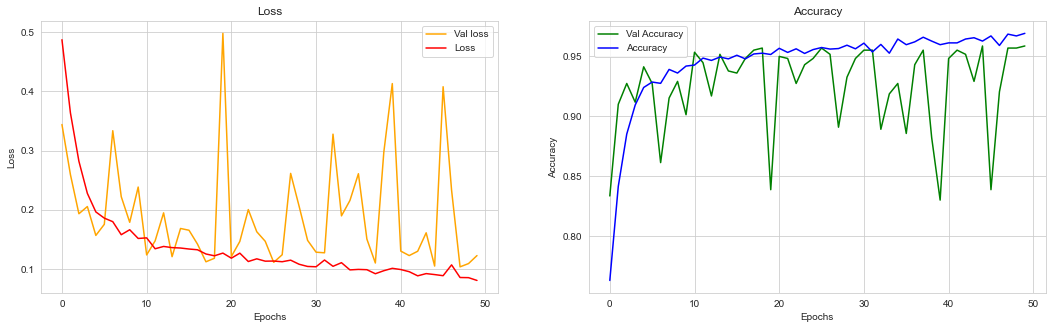

In [37]:
visualize_results(history)

In [38]:
baseline.metrics_names

['loss', 'acc']

Training Data Loss: 0.07268296182155609
Training Data Accuracy 0.9710051417350769
--------------------------
Validation Data Loss: 0.12265709787607193
Validation Data Accuracy 0.9583333134651184 

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92       158
         1.0       0.95      1.00      0.97       418

    accuracy                           0.96       576
   macro avg       0.97      0.93      0.95       576
weighted avg       0.96      0.96      0.96       576



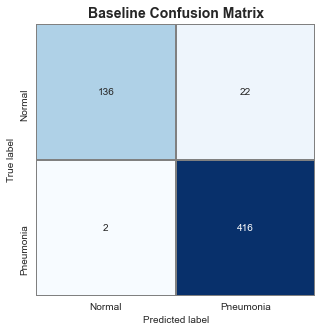

In [39]:
get_results(train_img, train_y, val_img, val_y, baseline, 'Baseline', 
            total_time)

Not bad for a baseline model! This model has a high accuracy score and did well at decreasing the false negatives.

### MLP with Dropout
Now we can begin really building up some layers, tuning hyperparameters, and using data augmentation.

In [40]:
#build a model with 3 hidden layers and dropout layers
dropout_MLP = Sequential()
dropout_MLP.add(layers.Dense(64, activation= 'relu', input_shape= (67500,)))
dropout_MLP.add(layers.Dropout(0.2))

dropout_MLP.add(layers.Dense(32, activation= 'relu'))
dropout_MLP.add(layers.Dropout(0.2))

dropout_MLP.add(layers.Dense(16, activation= 'relu'))
dropout_MLP.add(layers.Dropout(0.2))
dropout_MLP.add(layers.Dense(1, activation= 'sigmoid'))

# let's also change to using Adam as our optimizer
dropout_MLP.compile(optimizer= 'Adam', 
               loss= 'binary_crossentropy', 
               metrics=['acc'])

#fit model
start = datetime.datetime.now()
history2 = dropout_MLP.fit(train_img, train_y, 
           epochs= 40, 
           batch_size= 30, 
           validation_data= (val_img, val_y))

end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/40
156/156 [==============================] - 2s 11ms/step - loss: 0.9553 - acc: 0.6830 - val_loss: 0.3563 - val_acc: 0.7257
Epoch 2/40
156/156 [==============================] - 2s 10ms/step - loss: 0.4023 - acc: 0.7436 - val_loss: 0.2907 - val_acc: 0.7257
Epoch 3/40
156/156 [==============================] - 2s 11ms/step - loss: 0.3721 - acc: 0.7436 - val_loss: 0.2777 - val_acc: 0.7257
Epoch 4/40
156/156 [==============================] - 2s 11ms/step - loss: 0.3934 - acc: 0.7436 - val_loss: 0.2765 - val_acc: 0.7257
Epoch 5/40
156/156 [==============================] - 1s 9ms/step - loss: 0.3600 - acc: 0.7560 - val_loss: 0.2629 - val_acc: 0.9531
Epoch 6/40
156/156 [==============================] - 2s 13ms/step - loss: 0.3727 - acc: 0.7852 - val_loss: 0.3263 - val_acc: 0.8889
Epoch 7/40
156/156 [==============================] - 1s 10ms/step - loss: 0.3542 - acc: 0.7966 - val_loss: 0.2556 - val_acc: 0.9462
Epoch 8/40
156/156 [==============================] - 2s 10ms/step - l

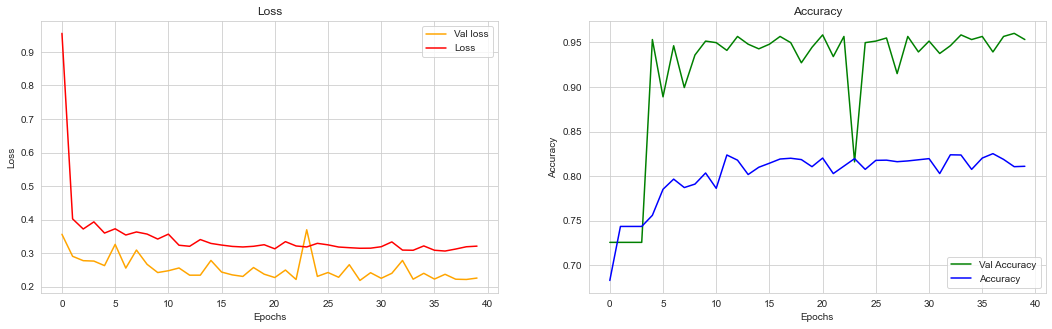

In [41]:
visualize_results(history2)

In [42]:
dropout_MLP.metrics_names

['loss', 'acc']

Training Data Loss: 0.19045905768871307
Training Data Accuracy 0.9656357169151306
--------------------------
Validation Data Loss: 0.22584864497184753
Validation Data Accuracy 0.953125 

              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       158
         1.0       0.99      0.95      0.97       418

    accuracy                           0.95       576
   macro avg       0.93      0.96      0.94       576
weighted avg       0.96      0.95      0.95       576



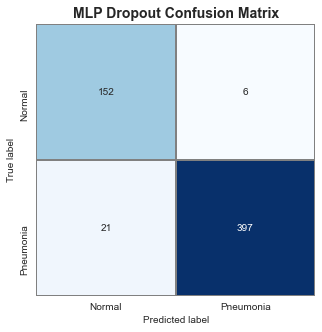

In [43]:
get_results(train_img, train_y, val_img, val_y, dropout_MLP, 'MLP Dropout', 
            total_time)

This model also performed fairly well in terms of accuracy. Let's see if we can get better results with different neural networks.

### CNN

In [44]:
# build Convolutional Neural Network with 4 hidden layers

cnn_base = Sequential()
cnn_base.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(150, 150, 3)))
cnn_base.add(layers.MaxPooling2D((2, 2)))

cnn_base.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_base.add(layers.MaxPooling2D((2, 2)))

cnn_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_base.add(layers.MaxPooling2D((2, 2)))

cnn_base.add(layers.Flatten())
cnn_base.add(layers.Dense(64, activation='relu'))
cnn_base.add(layers.Dense(1, activation='sigmoid'))

In [45]:
cnn_base.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [46]:
# use callbacks to reduce run times
# .{epoch:02d}-{val_loss:.2f} added to checkpoint name will create new file 
# for each model with the lowest val_loss and have epoch and val_loss in name
# not used here to minimize size of files

chckpt_filepath = './models/cnn_base.h5'  

model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True), 
                   TensorBoard(log_dir='./logs', update_freq= 5)]

#Compile and fit first CNN model

cnn_base.compile(optimizer= 'Adam', 
            loss= 'binary_crossentropy', 
            metrics= ['acc'])

start = datetime.datetime.now()
history3 = cnn_base.fit(train_images, train_y, epochs = 50, batch_size = 50,
                       validation_data = (val_images, val_y), 
                       callbacks = model_callbacks)
end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/50
 1/94 [..............................] - ETA: 0s - loss: 0.7019 - acc: 0.2600WARNING:tensorflow:From /Users/cassienutter/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
94/94 [==============================] - 49s 524ms/step - loss: 0.2952 - acc: 0.8769 - val_loss: 0.2395 - val_acc: 0.9062
Epoch 2/50
94/94 [==============================] - 48s 513ms/step - loss: 0.1188 - acc: 0.9558 - val_loss: 0.1157 - val_acc: 0.9549
Epoch 3/50
94/94 [==============================] - 47s 496ms/step - loss: 0.0982 - acc: 0.9641 - val_loss: 0.1023 - val_acc: 0.9618
Epoch 4/50
94/94 [==============================] - 49s 517ms/step - loss: 0.0816 - acc: 0.9684 - val_loss: 0.0574 - val_acc: 0.9792
Epoch 5/50
94/94 [==============================] - 47s 496ms/step - loss: 

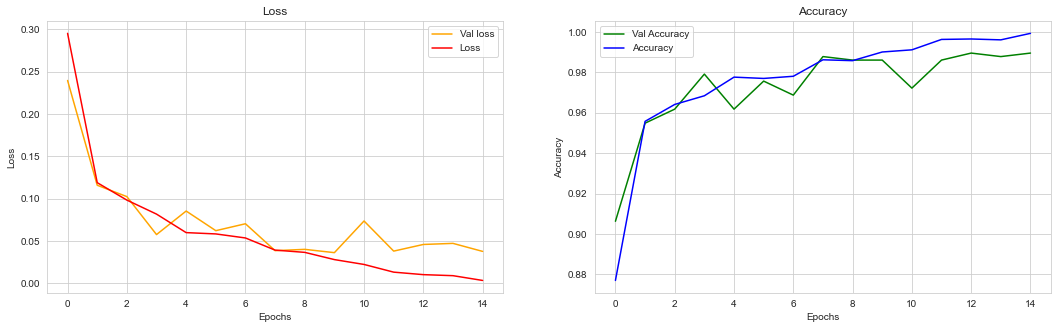

In [47]:
visualize_results(history3)

#### TensorBoard

In [48]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 78053), started 2 days, 20:08:42 ago. (Use '!kill 78053' to kill it.)

In [49]:
# This can be copied into command line, and returns url 

# tensorboard dev upload \
#   --logdir logs/ \
#   --name 'Baseline CNN' \
#   --one_shot

Training Data Loss: 0.01697560027241707
Training Data Accuracy 0.9933419227600098
--------------------------
Validation Data Loss: 0.03605194389820099
Validation Data Accuracy 0.9861111044883728 

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       158
         1.0       0.99      0.99      0.99       418

    accuracy                           0.99       576
   macro avg       0.98      0.98      0.98       576
weighted avg       0.99      0.99      0.99       576



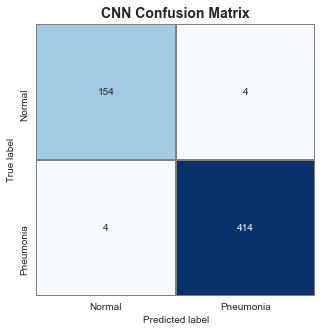

In [50]:
get_results(train_images, train_y, val_images, val_y, cnn_base, 'CNN', total_time)

This model performed well, and it's a good thing we had early stopping. We ended up not having to run through all 50 epochs.

#### View Feature Maps
Visualizing what the model is looking at is always interesting and exciting. Let's see what this model is up to.

(1, 150, 150, 3)


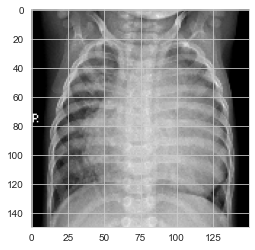

In [51]:
# view one image from pneumonia training set
img_path = train_pneum + 'person5_bacteria_15.jpeg'
img = load_img(img_path, target_size = (150,150))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis= 0)

img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

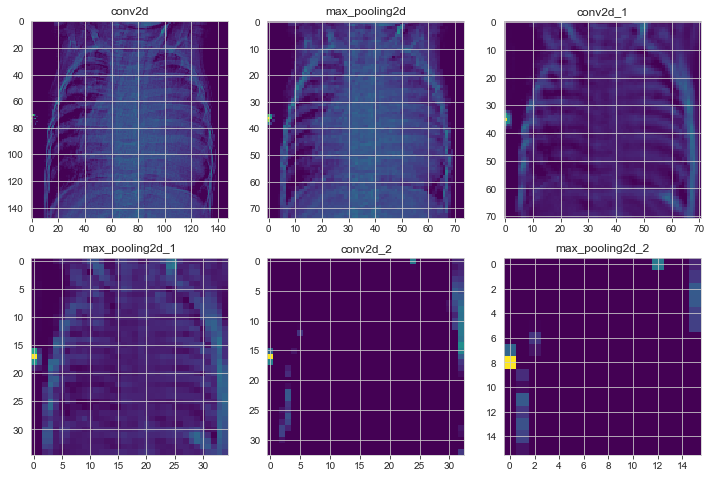

In [52]:
# view that image throughout 6 layers and see what patterns are detected
layer_outputs = [layer.output for layer in cnn_base.layers[:6]]
activation_model = models.Model(inputs= cnn_base.input, outputs= layer_outputs)

activations = activation_model.predict(img_tensor)

fig, axes = plt.subplots(2, 3, figsize= (12, 8))
layer_names = []
for layer in cnn_base.layers[:6]:
    layer_names.append(layer.name)
    
for i in range(6):
    row = i //3
    col = i % 3
    ax = axes[row, col]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 6], cmap= 'viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

#### View First Activation Layer

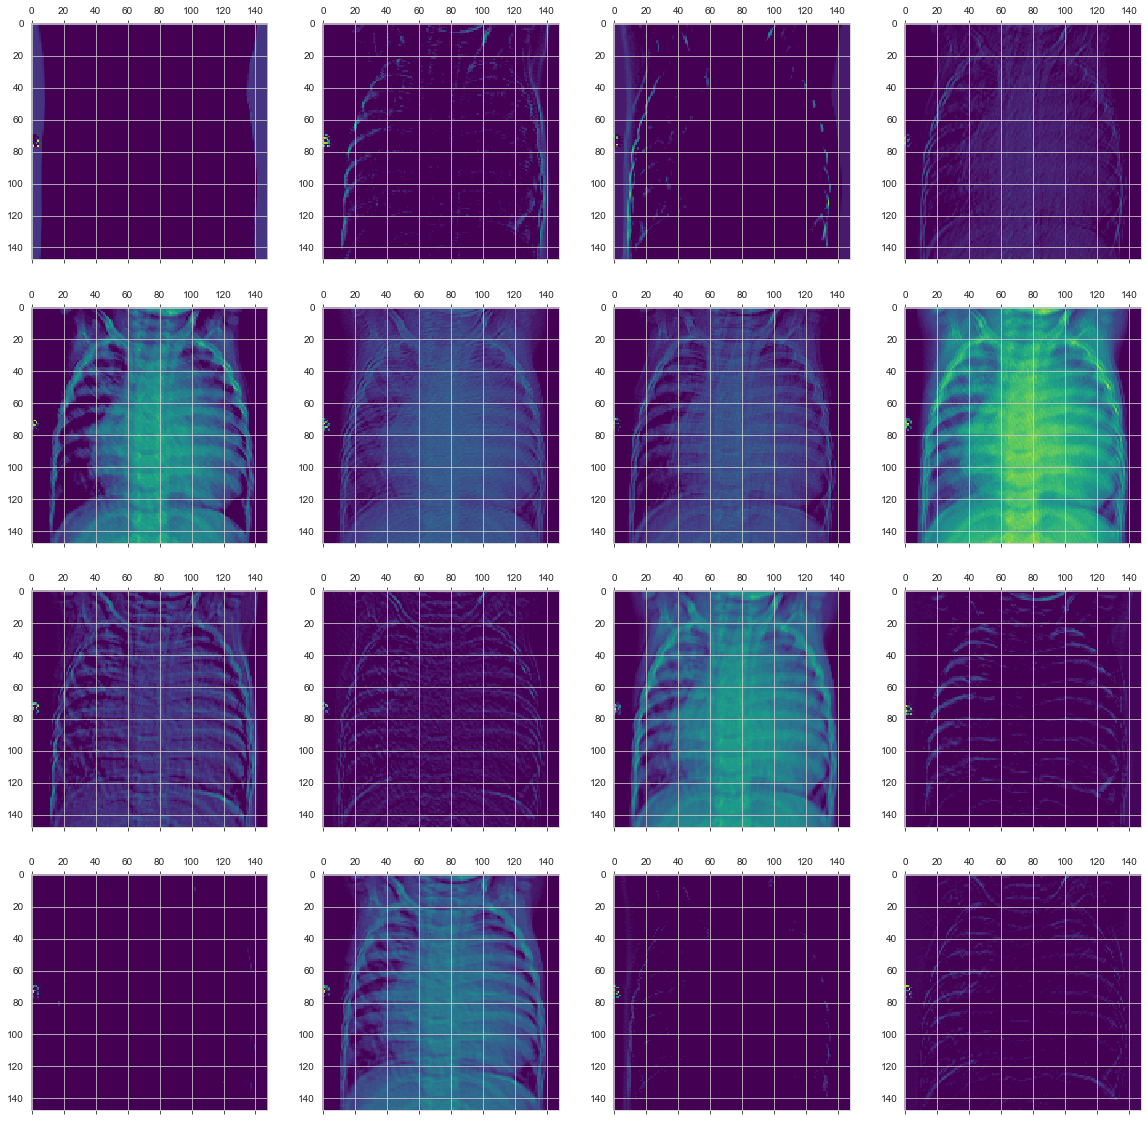

In [53]:
# visualize first 16 channels (out of 32) on first activation layer
layer_outputs = [layer.output for layer in cnn_base.layers[:8]]
activation_model = models.Model(inputs= cnn_base.input, outputs= layer_outputs)

activations = activation_model.predict(img_tensor)

fig, axes = plt.subplots(4, 4, figsize= (20, 20))
for i in range(16):
    row = i //4
    col = i % 4
    ax = axes[row, col]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap= 'viridis')

### CNN with Augmentation

Here we will see if we can reduce any overfitting by creating more data using our existing data. We will perform data augmentation to add slightly modified copies and see if it helps our model perform better.

In [54]:
# data augmentation 
train_datagen = ImageDataGenerator(rotation_range= 20, 
                                   width_shift_range= 0.1, 
                                   height_shift_range= 0.1, 
                                   shear_range= 0.2,
                                   horizontal_flip= False, 
                                   vertical_flip= False,
                                   zoom_range= 0.2)

In [55]:
#build layers for the model
cnn_aug = Sequential()

cnn_aug.add(layers.Conv2D(32, (3, 3), activation= 'relu', 
                          input_shape= (150, 150, 3)))
cnn_aug.add(layers.MaxPooling2D(2, 2))

cnn_aug.add(layers.Conv2D(32, (4, 4), activation= 'relu'))
cnn_aug.add(layers.MaxPooling2D(2, 2))

cnn_aug.add(layers.Conv2D(64, (3, 3), activation= 'relu'))
cnn_aug.add(layers.MaxPooling2D(2, 2))

cnn_aug.add(layers.Flatten())
cnn_aug.add(layers.Dense(64, activation= 'relu'))
cnn_aug.add(layers.Dense(1, activation= 'sigmoid'))

In [56]:
#make new filepath for the callback
chckpt_filepath = './models/cnn_aug.h5'
model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]

#compile and fit new model
cnn_aug.compile(optimizer= 'Adam', 
                loss= 'binary_crossentropy', 
                metrics= ['acc'])

start = datetime.datetime.now()
history4 = cnn_aug.fit(train_datagen.flow(train_images, train_y), 
                       epochs= 50,
                       validation_data= (val_images, val_y), 
                       callbacks = model_callbacks)

end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/50
146/146 [==============================] - 51s 350ms/step - loss: 0.5266 - acc: 0.7685 - val_loss: 0.3230 - val_acc: 0.8889
Epoch 2/50
146/146 [==============================] - 56s 382ms/step - loss: 0.3422 - acc: 0.8486 - val_loss: 0.2865 - val_acc: 0.8785
Epoch 3/50
146/146 [==============================] - 53s 365ms/step - loss: 0.2853 - acc: 0.8829 - val_loss: 0.2171 - val_acc: 0.9201
Epoch 4/50
146/146 [==============================] - 48s 327ms/step - loss: 0.2703 - acc: 0.8864 - val_loss: 0.1613 - val_acc: 0.9375
Epoch 5/50
146/146 [==============================] - 48s 326ms/step - loss: 0.2334 - acc: 0.9089 - val_loss: 0.1669 - val_acc: 0.9392
Epoch 6/50
146/146 [==============================] - 47s 323ms/step - loss: 0.2185 - acc: 0.9139 - val_loss: 0.1646 - val_acc: 0.9410
Epoch 7/50
146/146 [==============================] - 47s 319ms/step - loss: 0.2187 - acc: 0.9111 - val_loss: 0.1542 - val_acc: 0.9444
Epoch 8/50
146/146 [==============================] - 4

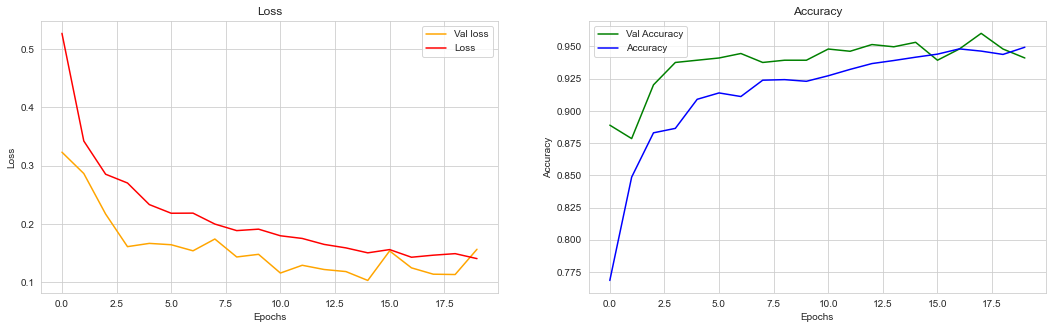

In [57]:
visualize_results(history4)

Training Data Loss: 0.10534746944904327
Training Data Accuracy 0.9579038023948669
--------------------------
Validation Data Loss: 0.10344938933849335
Validation Data Accuracy 0.953125 

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       158
         1.0       0.98      0.96      0.97       418

    accuracy                           0.95       576
   macro avg       0.94      0.95      0.94       576
weighted avg       0.95      0.95      0.95       576



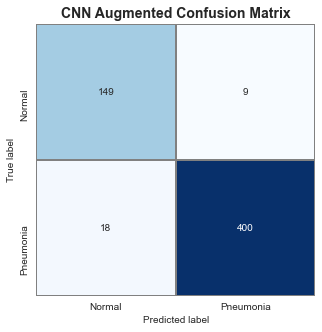

In [58]:
get_results(train_images, train_y, val_images, val_y, cnn_aug, 'CNN Augmented', 
            total_time)

#### View Augmented Images
It is interesting to see what the images look like after we manipulated them. Let's look at how an image was altered by the model.

(1, 150, 150, 3)


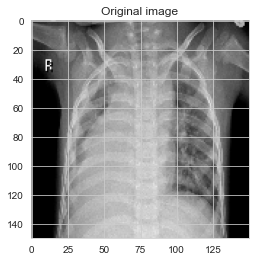

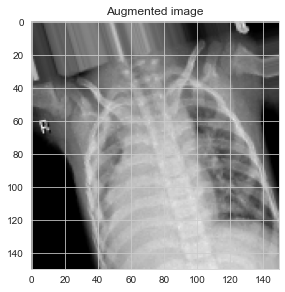

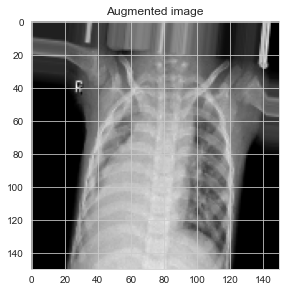

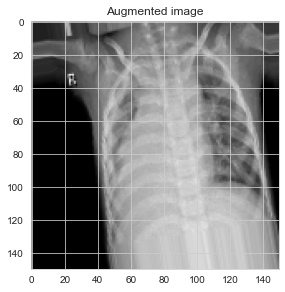

In [109]:
names = [os.path.join(train_pneum, name) for name in os.listdir(train_pneum)]
img_path = names[89]
img = load_img(img_path, target_size= (150,150))

reshape_img = img_to_array(img)
reshape_img = np.expand_dims(reshape_img, axis= 0)

img_tensor = np.expand_dims(img_tensor, axis= 0)

reshape_img /= 255.
print(reshape_img.shape)

plt.imshow(reshape_img[0])
plt.title('Original image')
plt.show()


i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    plt.tight_layout()
    plt.title('Augmented image')
    i += 1
    if i % 3 == 0:
        break
plt.show()

#### View Feature Maps
Again, let's take a peak at what the model is doing with the images and how it is learning.

(1, 150, 150, 3)


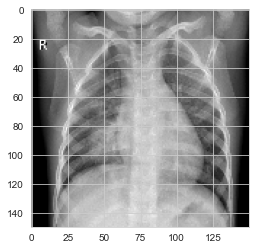

In [60]:
# View an image 

img_path = train_pneum + 'person8_bacteria_37.jpeg'
img = image.load_img(img_path, target_size = (150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis= 0)

img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

In [61]:
# check the model's layers
cnn_aug.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 71, 71, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)            

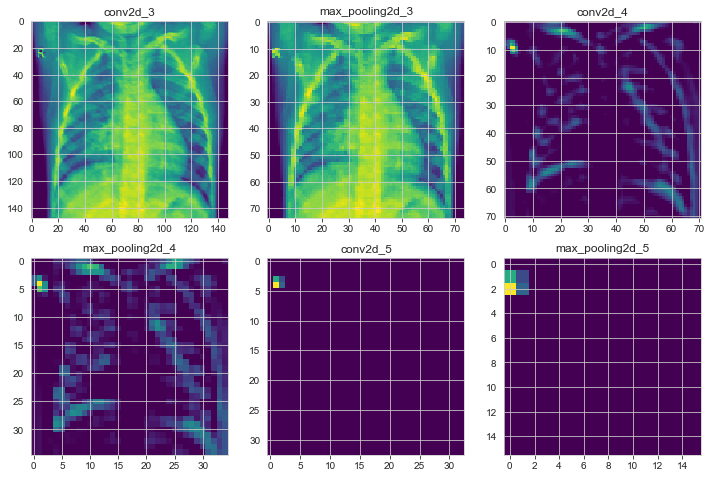

In [62]:
# View that one image on the 4th channel across all activation layers
layer_outputs = [layer.output for layer in cnn_aug.layers[:6]]
activation_model = models.Model(inputs= cnn_aug.input, outputs= layer_outputs)

activations = activation_model.predict(img_tensor)

fig, axes = plt.subplots(2, 3, figsize= (12, 8))
layer_names = []
for layer in cnn_aug.layers[:6]:
    layer_names.append(layer.name)
    
for i in range(6):
    row = i //3
    col = i % 3
    ax = axes[row, col]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 4], cmap= 'viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

This model found some discernible pattern to learn from on each layer

### CNN with Dropout and Class Weights

In [63]:
# build layers of CNN with Dropout to reduce overfitting
cnn_dropout = Sequential()

cnn_dropout.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(150, 150, 3)))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))

cnn_dropout.add(layers.Conv2D(64, (4, 4), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_dropout.add(layers.Dropout(0.2))

cnn_dropout.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_dropout.add(layers.Dropout(0.2))

cnn_dropout.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))

cnn_dropout.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_dropout.add(layers.MaxPooling2D((2, 2)))
cnn_dropout.add(layers.Dropout(0.2))

cnn_dropout.add(layers.Flatten())
cnn_dropout.add(layers.Dense(128, activation='relu'))
cnn_dropout.add(layers.Dense(1, activation='sigmoid'))

In [64]:
cnn_dropout.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)       

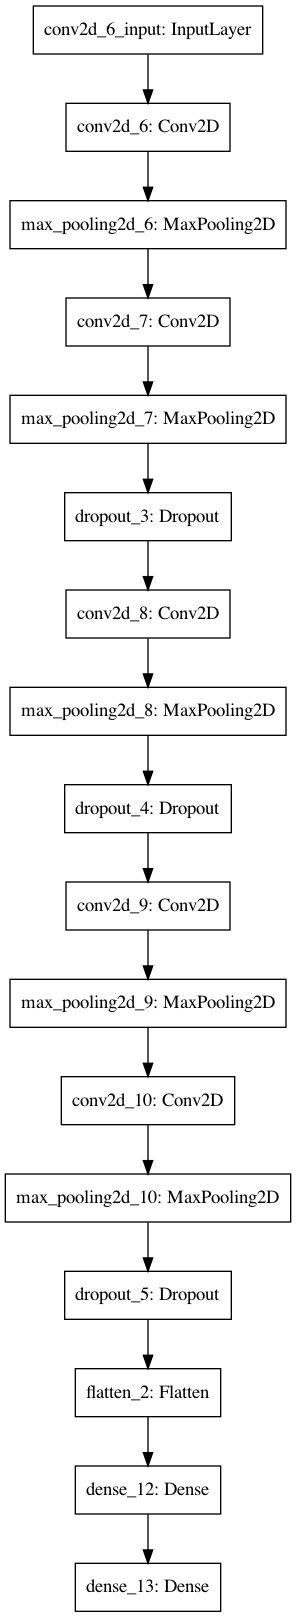

In [111]:
#visualize model layers
plot_model(cnn_dropout, to_file='images/cnn_drop.png')

In [65]:
#make new filepath for the callback
chckpt_filepath = './models/cnn_dropout.h5'
model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]

# compile and fit data
cnn_dropout.compile(optimizer= 'Adam', 
                    loss= 'binary_crossentropy', 
                    metrics= ['acc'])

# adjust class_weights parameter to account for class imbalance
start = datetime.datetime.now()
history5 = cnn_dropout.fit(train_images, train_y, batch_size= 30, epochs= 40, 
                           validation_data= (val_images, val_y),
                           callbacks= model_callbacks, 
                           class_weight= {0:.25, 1:6})

end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/40
156/156 [==============================] - 63s 406ms/step - loss: 0.3964 - acc: 0.7412 - val_loss: 0.8056 - val_acc: 0.7257
Epoch 2/40
156/156 [==============================] - 64s 408ms/step - loss: 0.3225 - acc: 0.7455 - val_loss: 0.4733 - val_acc: 0.7622
Epoch 3/40
156/156 [==============================] - 63s 402ms/step - loss: 0.2378 - acc: 0.7805 - val_loss: 0.4326 - val_acc: 0.7847
Epoch 4/40
156/156 [==============================] - 63s 402ms/step - loss: 0.2062 - acc: 0.7970 - val_loss: 0.3283 - val_acc: 0.8646
Epoch 5/40
156/156 [==============================] - 62s 400ms/step - loss: 0.2007 - acc: 0.8076 - val_loss: 0.4637 - val_acc: 0.8073
Epoch 6/40
156/156 [==============================] - 66s 423ms/step - loss: 0.1550 - acc: 0.8533 - val_loss: 0.3356 - val_acc: 0.8941
Epoch 7/40
156/156 [==============================] - 63s 405ms/step - loss: 0.1542 - acc: 0.8557 - val_loss: 0.3047 - val_acc: 0.8715
Epoch 8/40
156/156 [==============================] - 6

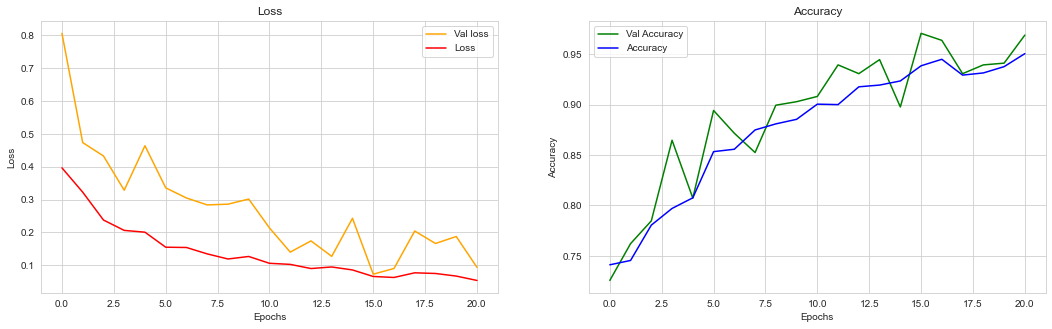

In [66]:
visualize_results(history5)

Training Data Loss: 0.056453194469213486
Training Data Accuracy 0.9798110127449036
--------------------------
Validation Data Loss: 0.07300127297639847
Validation Data Accuracy 0.9704861044883728 

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94       158
         1.0       0.97      0.99      0.98       418

    accuracy                           0.97       576
   macro avg       0.97      0.95      0.96       576
weighted avg       0.97      0.97      0.97       576



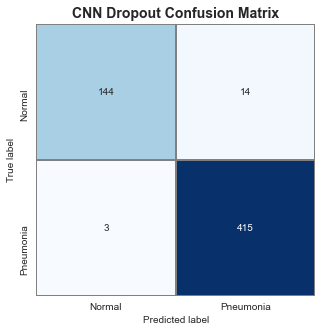

In [67]:
get_results(train_images, train_y, val_images, val_y, cnn_dropout, 
            'CNN Dropout', total_time)

### L2 Regularization

In [68]:
L2_model = Sequential()

L2_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=(150, 150, 3)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_regularizer = regularizers.l2(0.005)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = regularizers.l2(0.005)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer = regularizers.l2(0.005)))
L2_model.add(layers.MaxPooling2D((2, 2)))

L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(128, activation='relu'))
L2_model.add(layers.Dense(1, activation='sigmoid'))

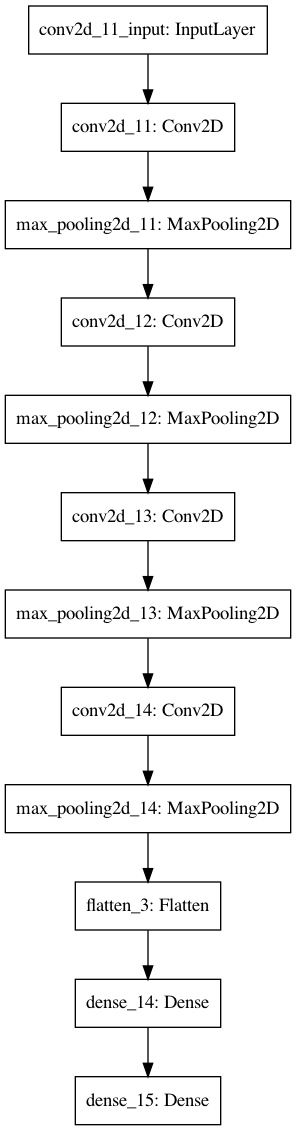

In [69]:
#show model structure

# L2_model.summary()
plot_model(L2_model, to_file='images/L2.png')

In [70]:
# use callbacks to reduce run times
chckpt_filepath = './models/L2_model.h5'

model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]

L2_model.compile(optimizer= 'Adam', loss= 'binary_crossentropy', metrics= ['acc'])

start = datetime.datetime.now()
history6 = L2_model.fit(train_images, train_y, epochs= 50, batch_size= 50, 
                  callbacks= model_callbacks, 
                  validation_data= (val_images, val_y))

end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/50
94/94 [==============================] - 72s 768ms/step - loss: 0.7631 - acc: 0.8101 - val_loss: 0.3561 - val_acc: 0.9288
Epoch 2/50
94/94 [==============================] - 73s 772ms/step - loss: 0.2781 - acc: 0.9366 - val_loss: 0.2175 - val_acc: 0.9514
Epoch 3/50
94/94 [==============================] - 73s 781ms/step - loss: 0.2014 - acc: 0.9517 - val_loss: 0.1826 - val_acc: 0.9462
Epoch 4/50
94/94 [==============================] - 70s 741ms/step - loss: 0.1739 - acc: 0.9545 - val_loss: 0.2648 - val_acc: 0.9201
Epoch 5/50
94/94 [==============================] - 72s 766ms/step - loss: 0.1502 - acc: 0.9635 - val_loss: 0.1465 - val_acc: 0.9549
Epoch 6/50
94/94 [==============================] - 61s 648ms/step - loss: 0.1437 - acc: 0.9611 - val_loss: 0.1864 - val_acc: 0.9392
Epoch 7/50
94/94 [==============================] - 62s 661ms/step - loss: 0.1288 - acc: 0.9639 - val_loss: 0.1271 - val_acc: 0.9566
Epoch 8/50
94/94 [==============================] - 66s 697ms/step - 

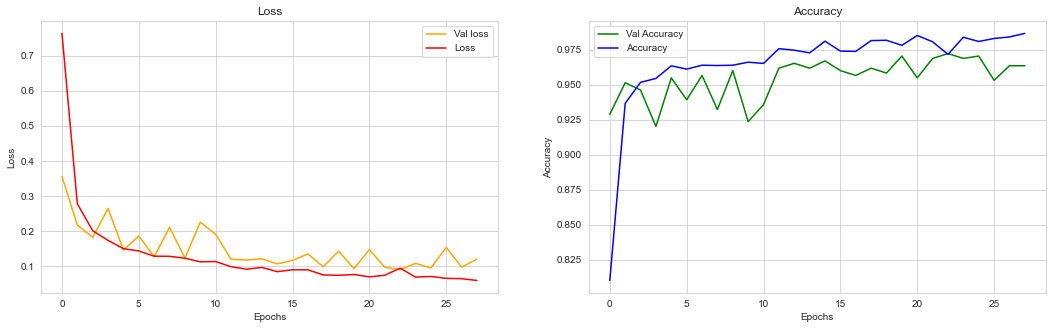

In [71]:
visualize_results(history6)

Training Data Loss: 0.06191989779472351
Training Data Accuracy 0.9871134161949158
--------------------------
Validation Data Loss: 0.09044718742370605
Validation Data Accuracy 0.9722222089767456 

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       158
         1.0       0.98      0.99      0.98       418

    accuracy                           0.97       576
   macro avg       0.97      0.96      0.96       576
weighted avg       0.97      0.97      0.97       576



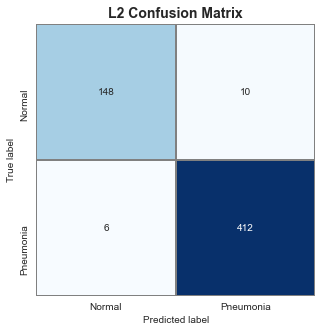

In [72]:
get_results(train_images, train_y, val_images, val_y, L2_model, 'L2', total_time)

### Transfer Learning

In [73]:
#Instantiate VGG19
VGG = VGG19(include_top=False,
                   weights='imagenet',
                   input_shape=(150, 150,3))

VGG.trainable = False

In [74]:
VGG.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [75]:
# Build the model, add VGG 19 and add layers
vgg_model = Sequential()

vgg_model.add(VGG)

vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(units=128, activation='relu', kernel_regularizer='l2'))
vgg_model.add(layers.Dropout(0.2))

vgg_model.add(layers.Dense(units=64, activation='relu', kernel_regularizer='l2'))
vgg_model.add(layers.Dropout(0.2))
vgg_model.add(layers.Dense(units=1, activation='sigmoid', kernel_regularizer='l2'))

In [76]:
# set checkpoint and early stopping
# VGG model checkpoint stored locally due to GitHub limits
chckpt_filepath = '../models/vgg_model.h5'
model_callbacks = [EarlyStopping(monitor= 'val_loss', 
                                 patience= 5, 
                                 restore_best_weights= True), 
                   ModelCheckpoint(filepath= chckpt_filepath, 
                                   monitor= 'val_loss', 
                                   save_best_only= True)]
# Compile model
vgg_model.compile(loss = 'binary_crossentropy',
              optimizer = 'Nadam',
              metrics = ['acc'])

# Fit model and save fitting time
start = datetime.datetime.now()
history7 = vgg_model.fit(train_images, train_y, 
                         epochs = 50, 
                         batch_size = 100,
                         validation_data = (val_images, val_y), 
                         callbacks = model_callbacks)

end = datetime.datetime.now()
total_time = (end-start).total_seconds() / 60

Epoch 1/50
47/47 [==============================] - 335s 7s/step - loss: 1.8748 - acc: 0.8677 - val_loss: 1.1587 - val_acc: 0.8247
Epoch 2/50
47/47 [==============================] - 332s 7s/step - loss: 0.8347 - acc: 0.9223 - val_loss: 0.6812 - val_acc: 0.9358
Epoch 3/50
47/47 [==============================] - 308s 7s/step - loss: 0.5572 - acc: 0.9491 - val_loss: 0.4656 - val_acc: 0.9462
Epoch 4/50
47/47 [==============================] - 307s 7s/step - loss: 0.4388 - acc: 0.9454 - val_loss: 0.4276 - val_acc: 0.9323
Epoch 5/50
47/47 [==============================] - 307s 7s/step - loss: 0.3828 - acc: 0.9424 - val_loss: 0.3521 - val_acc: 0.9410
Epoch 6/50
47/47 [==============================] - 307s 7s/step - loss: 0.3203 - acc: 0.9553 - val_loss: 0.3415 - val_acc: 0.9375
Epoch 7/50
47/47 [==============================] - 307s 7s/step - loss: 0.3040 - acc: 0.9452 - val_loss: 0.2931 - val_acc: 0.9479
Epoch 8/50
47/47 [==============================] - 307s 7s/step - loss: 0.2654 - a

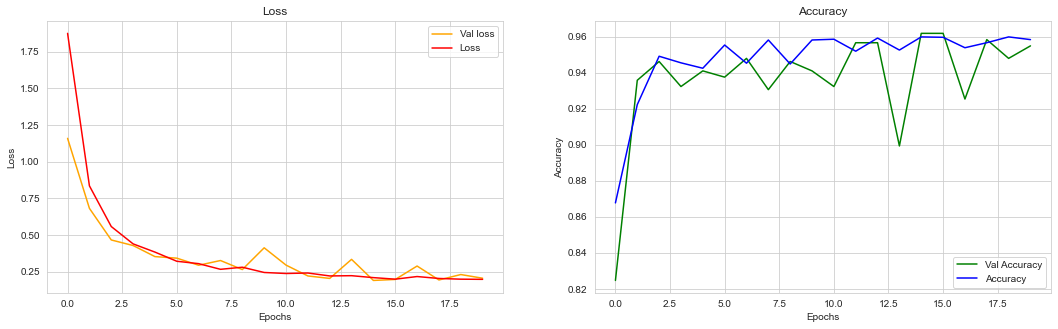

In [77]:
visualize_results(history7)

Training Data Loss: 0.1625663936138153
Training Data Accuracy 0.9763745665550232
--------------------------
Validation Data Loss: 0.18944524228572845
Validation Data Accuracy 0.9618055820465088 

              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       158
         1.0       0.97      0.98      0.97       418

    accuracy                           0.96       576
   macro avg       0.96      0.95      0.95       576
weighted avg       0.96      0.96      0.96       576



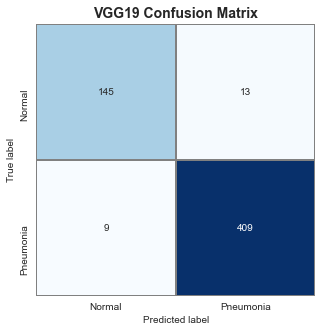

In [78]:
get_results(train_images, train_y, val_images, val_y, vgg_model, 'VGG19', 
            total_time)

## Results:

### See Results from Models

Let's put it all together and see if we can find the best model.

In [79]:
# create DataFrame from results list
results_df = pd.DataFrame(results_list, 
                          columns = ['Model', 'Train Loss', 'Val Loss',
                                     'Train Accuracy', 'Val Accuracy', 
                                     'False Negatives', 'Run Time'])
results_df.sort_values(by= ['Val Accuracy'], ascending= False, inplace= True)
results_df.reset_index(drop= True)

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,False Negatives,Run Time
0,CNN,0.0170,0.0361,99.33,98.61,4,11.963712
1,L2,0.0619,0.0904,98.71,97.22,6,30.417743
2,CNN Dropout,0.0565,0.0730,97.98,97.05,3,23.435606
3,VGG19,0.1626,0.1894,97.64,96.18,9,105.332362
4,Baseline,0.0727,0.1227,97.10,95.83,2,0.892369
5,MLP Dropout,0.1905,0.2258,96.56,95.31,21,1.123846
6,CNN Augmented,0.1053,0.1034,95.79,95.31,18,17.053304


Text(0.5, 0, '% Accuracy')

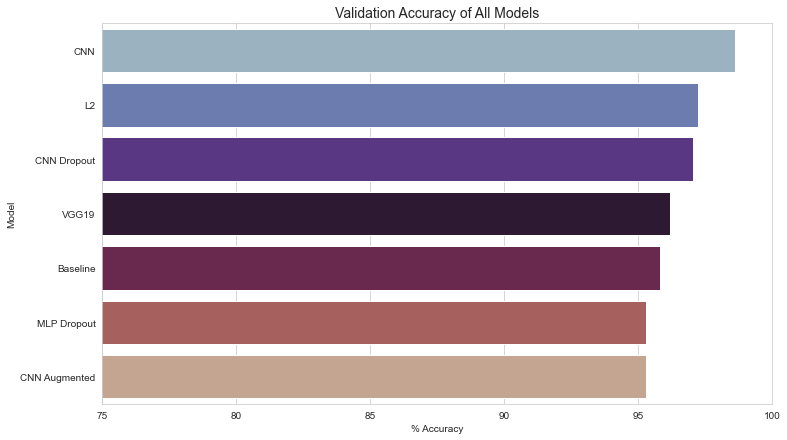

In [80]:
# graph validation accuracy
plt.figure(figsize= (12, 7))
sns.barplot(x= results_df['Val Accuracy'], y= results_df['Model'], palette= 'twilight')
plt.xlim(75,100)
plt.title('Validation Accuracy of All Models', fontsize= 14)
plt.xlabel('% Accuracy')

All models were able to score above 95% on the training and validation data.

Text(0.5, 0, 'Minutes')

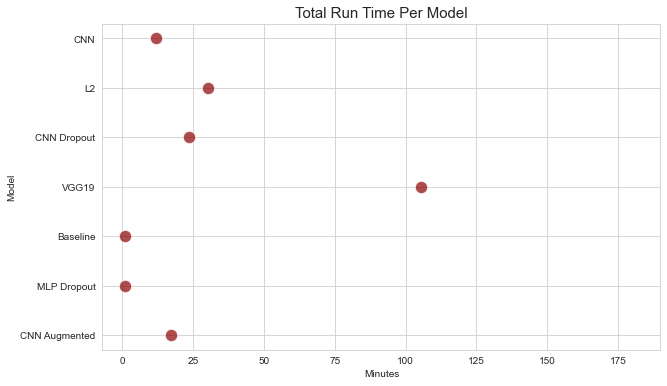

In [81]:
# See how long it took to train each model
plt.figure(figsize= (10,6))
sns.scatterplot(y= results_df['Model'], x= results_df['Run Time'], 
                data= results_df, s=150, color= 'darkred', alpha= 0.7)
plt.xlim(-7,190)
plt.title('Total Run Time Per Model', fontsize= 15)
plt.xlabel('Minutes')

Most models were able to train in 30 minutes or less, with the exception of the VGG19 model.

### See Test Results

We've seen how the models do when compared to the validation data, but how well do the work when looking at the unseen test data?

Only showing the top 4 performing models here:

In [82]:
# get accuracy and loss when evaluating against test set
test_results = []
models_var = [cnn_base, L2_model, cnn_aug, cnn_dropout, vgg_model]

# function to get test results from CNN and VGG19 models
def get_test_results(model_var_list):
    for var in model_var_list:
        results_loss, results_acc = var.evaluate(test_images, test_y, verbose= 0)
        test_results.append((round(results_acc*100, 2), round(results_loss,4)))

In [83]:
# call function that gets results and puts them in list
get_test_results(models_var)

In [84]:
# get results for baseline MLP
base_loss, base_acc = baseline.evaluate(test_img, test_y)

20/20 [==============================] - 0s 4ms/step - loss: 1.3580 - acc: 0.7260


In [85]:
# get results for Dropout MLP
MLP_loss, MLP_acc = dropout_MLP.evaluate(test_img, test_y)

20/20 [==============================] - 0s 3ms/step - loss: 0.7935 - acc: 0.7965


In [86]:
# add baseline and dropout MLP results to list
test_results.append((round(base_acc*100, 2), round(base_loss,4)))
test_results.append((round(MLP_acc*100, 2), round(MLP_loss,4)))

In [87]:
test_results

[(78.85, 1.4482),
 (75.48, 1.118),
 (88.14, 0.3858),
 (76.92, 0.8335),
 (75.64, 0.7668),
 (72.6, 1.358),
 (79.65, 0.7935)]

In [88]:
# turn elements of list into df
columns = ['Test Accuracy', 'Test Loss']
model_names = ['CNN', 'L2', 'CNN Augmented', 'CNN Dropout', 'VGG19', 
               'Baseline', 'MLP Dropout']

test_results_df = pd.DataFrame(test_results, columns= columns)
test_results_df.insert(0, 'Model', model_names)

In [89]:
test_results_df

,Model,Test Accuracy,Test Loss
0,CNN,78.85,1.4482
1,L2,75.48,1.1180
2,CNN Augmented,88.14,0.3858
3,CNN Dropout,76.92,0.8335
4,VGG19,75.64,0.7668
5,Baseline,72.60,1.3580
6,MLP Dropout,79.65,0.7935


In [90]:
test_results_df.sort_values(by=['Test Accuracy'], ascending= False, inplace= True)

Text(0.5, 0, '% Accuracy')

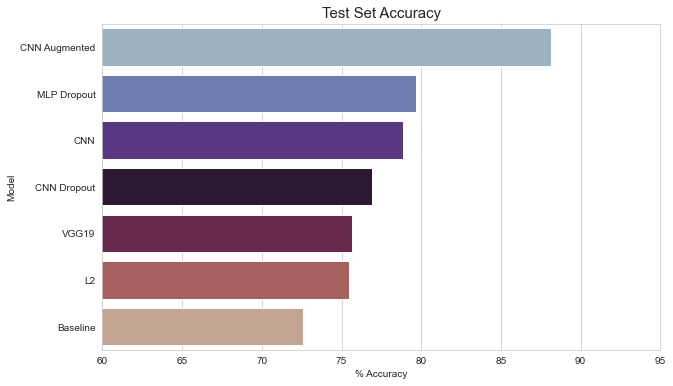

In [91]:
# visualize accuracy of test set
plt.figure(figsize= (10, 6))
sns.barplot(x=test_results_df['Test Accuracy'], y= test_results_df['Model'], 
            palette= 'twilight')
plt.xlim(60, 95)
plt.title('Test Set Accuracy', fontsize= 15)
plt.xlabel('% Accuracy')

Compare training and test accuracy scores

In [92]:
# Merge DataFrames together to view train and test accuracies
together_df = results_df.merge(test_results_df, how= 'inner', on= 'Model')

In [93]:
together_df.sort_values(by= ['Test Accuracy', 'Train Accuracy'], 
                        ascending= False, inplace= True)
together_df.reset_index(inplace= True, drop= True)
together_df

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,False Negatives,Run Time,Test Accuracy,Test Loss
0,CNN Augmented,0.1053,0.1034,95.79,95.31,18,17.053304,88.14,0.3858
1,MLP Dropout,0.1905,0.2258,96.56,95.31,21,1.123846,79.65,0.7935
2,CNN,0.0170,0.0361,99.33,98.61,4,11.963712,78.85,1.4482
3,CNN Dropout,0.0565,0.0730,97.98,97.05,3,23.435606,76.92,0.8335
4,VGG19,0.1626,0.1894,97.64,96.18,9,105.332362,75.64,0.7668
5,L2,0.0619,0.0904,98.71,97.22,6,30.417743,75.48,1.1180
6,Baseline,0.0727,0.1227,97.10,95.83,2,0.892369,72.60,1.3580


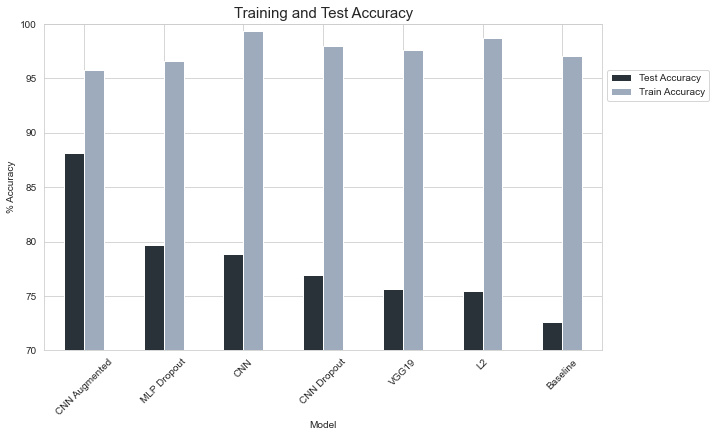

In [94]:
# plot difference in Train and Test Accuracy
together_df.plot(x= 'Model', y= ['Test Accuracy', 'Train Accuracy'], kind= 'bar', 
                 figsize= (10, 6), ylim=(70,100), color= ['#283238', '#9eabbd']) 


plt.title('Training and Test Accuracy', fontsize= 15)
plt.xticks(rotation= (45))
plt.ylabel('% Accuracy')
plt.legend(loc = 'lower right', bbox_to_anchor= (1.2, .75))

### Confusion Matrices for Test Set

Now, because accuracy isn't everything, let's see which of the models is the best at classifying radiographs from the test set.

In [95]:
# empty list to save false negatives
fn_list = []

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82       234
         1.0       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.85      0.86       624
weighted avg       0.89      0.88      0.88       624



Text(0.5, 1.0, 'CNN Augmented Confusion Matrix')

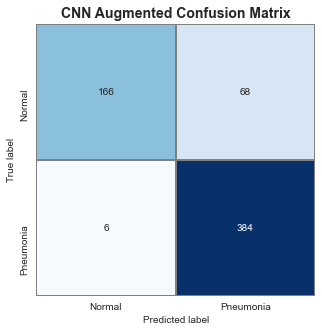

In [96]:
# CNN Augmented classification report and confusion matrix for test set

# print classification report
y_pred = cnn_aug.predict(test_images)
y_pred = np.rint(y_pred)
print(classification_report(test_y, y_pred))
    
# display confusion matrix
cm = confusion_matrix(test_y, y_pred)
FN = cm[1][0]
fn_list.append(('CNN Augmented', FN))

    
plt.figure(figsize= (5,5))
categories = ['Normal', 'Pneumonia']
sns.heatmap(cm, annot= True, cmap='Blues', fmt= 'g', 
            xticklabels= categories, yticklabels= categories, 
            cbar= False, linewidths= 1, linecolor='gray')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN Augmented Confusion Matrix', fontsize= 14, fontweight= 'bold')

              precision    recall  f1-score   support

         0.0       1.00      0.38      0.56       234
         1.0       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.87      0.69      0.70       624
weighted avg       0.83      0.77      0.74       624



Text(0.5, 1.0, 'CNN Dropout Confusion Matrix')

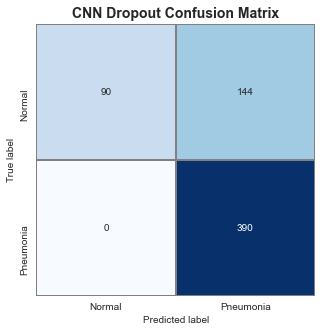

In [97]:
# CNN Dropout classification report and confusion matrix

# print classification report
y_pred = cnn_dropout.predict(test_images)
y_pred = np.rint(y_pred)
print(classification_report(test_y, y_pred))
    
# display confusion matrix
cm = confusion_matrix(test_y, y_pred)
FN = cm[1][0]
fn_list.append(('CNN Dropout', FN))

    
plt.figure(figsize= (5,5))
categories = ['Normal', 'Pneumonia']
sns.heatmap(cm, annot= True, cmap='Blues', fmt= 'g', 
            xticklabels= categories, yticklabels= categories, 
            cbar= False, linewidths= 1, linecolor='gray')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN Dropout Confusion Matrix', fontsize= 14, fontweight= 'bold')

              precision    recall  f1-score   support

         0.0       0.97      0.36      0.52       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.68      0.68       624
weighted avg       0.81      0.75      0.72       624



Text(0.5, 1.0, 'L2 Confusion Matrix')

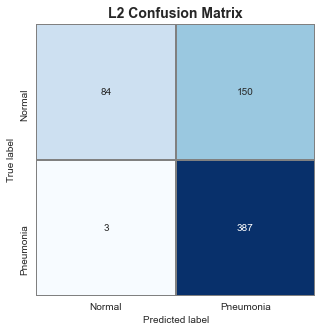

In [98]:
# L2 classification report and confusion matrix

# print classification report
y_pred = L2_model.predict(test_images)
y_pred = np.rint(y_pred)
print(classification_report(test_y, y_pred))
    
# display confusion matrix
cm = confusion_matrix(test_y, y_pred)
FN = cm[1][0]
fn_list.append(('L2', FN))

    
plt.figure(figsize= (5,5))
categories = ['Normal', 'Pneumonia']
sns.heatmap(cm, annot= True, cmap='Blues', fmt= 'g', 
            xticklabels= categories, yticklabels= categories, 
            cbar= False, linewidths= 1, linecolor='gray')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('L2 Confusion Matrix', fontsize= 14, fontweight= 'bold')

              precision    recall  f1-score   support

         0.0       0.98      0.36      0.52       234
         1.0       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



Text(0.5, 1.0, 'VGG19 Confusion Matrix')

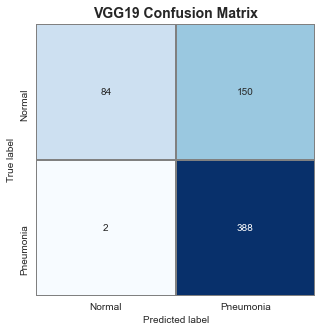

In [99]:
# VGG classifcation report and confusion matrix

# print classification report
y_pred = vgg_model.predict(test_images)
y_pred = np.rint(y_pred)
print(classification_report(test_y, y_pred))
    
# display confusion matrix
cm = confusion_matrix(test_y, y_pred)
FN = cm[1][0]
fn_list.append(('VGG19', FN))

    
plt.figure(figsize= (5,5))
categories = ['Normal', 'Pneumonia']
sns.heatmap(cm, annot= True, cmap='Blues', fmt= 'g', 
            xticklabels= categories, yticklabels= categories, 
            cbar= False, linewidths= 1, linecolor='gray')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('VGG19 Confusion Matrix', fontsize= 14, fontweight= 'bold')

In [100]:
fn_list_df = pd.DataFrame(fn_list, columns= ['Model', 'Test False Neg'])

In [101]:
fn_list_df

,Model,Test False Neg
0,CNN Augmented,6
1,CNN Dropout,0
2,L2,3
3,VGG19,2


In [102]:
# Merge DataFrames together to view train and test accuracies
together_df = results_df.merge(fn_list_df, how= 'inner', on= 'Model')

together_df.sort_values(by= ['Test False Neg'], ascending= True, inplace= True)
together_df.reset_index(inplace= True, drop= True)
together_df

,Model,Train Loss,Val Loss,Train Accuracy,Val Accuracy,False Negatives,Run Time,Test False Neg
0,CNN Dropout,0.0565,0.0730,97.98,97.05,3,23.435606,0
1,VGG19,0.1626,0.1894,97.64,96.18,9,105.332362,2
2,L2,0.0619,0.0904,98.71,97.22,6,30.417743,3
3,CNN Augmented,0.1053,0.1034,95.79,95.31,18,17.053304,6


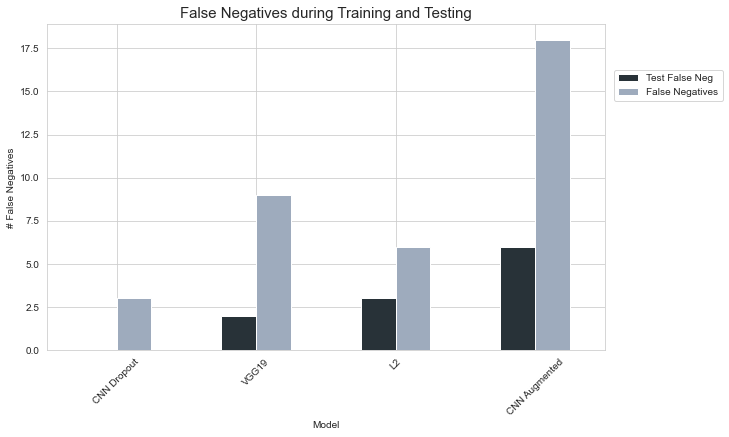

In [103]:
# plot difference in Train and Test Accuracy
together_df.plot(x= 'Model', y= ['Test False Neg', 'False Negatives'], 
                 kind= 'bar', figsize= (10, 6), color= ['#283238', '#9eabbd'])


plt.title('False Negatives during Training and Testing', fontsize= 15)
plt.xticks(rotation= (45))
plt.ylabel('# False Negatives')
plt.legend(loc = 'lower right', bbox_to_anchor= (1.22, .75))

We can see here that the models were fairly successful at reducing the amount of false negatives, or X-rays that have pneumonia but model predicted they were normal. These can be especially dangerous to the patient, and thus, are good to minimize. However, minimizing this value results in a larger number of normal radiographs classified as having pneumonia(aka false positives). 

A way to help prevent this in the future may be to give the model more normal radiographs during the training and validation phases. However, that trade-off between false negatives and false positives may always exist.

## Conclusion:

* Highest Training and Validation Accuracy: CNN
* Highest Test Accuracy: CNN Augmented
* Lowest # of False Negatives: CNN with Dropout layers

Because we are looking at medical data and patients, accuracy isn't everything. We definitely want our model to be accurate, but we are also okay with losing some accuracy if it means we can prevent the model from misdiagnosing children that do have pneumonia. 

While the VGG19 model performed really well, it's exorbitant fitting time compared to the other models isn't very efficient considering time and memory constraints may be an issue.

For that reason, arguments for the best models could be made for:

* CNN with Augmentation-- for the highest test accuracy, fastest fit time, and a low false negative rate of 1.6%
    * This model also has the lowest false positive rate at 29%
* CNN with Dropout-- for the next highest test accuracy and false positive rate of 0